In [1]:
# Torch and related packages
import torch
from torchvision import transforms, datasets, utils
import torch.nn.functional as F
from PIL import Image

# Math and plot utils
import numpy as np
import matplotlib.pyplot as plt

# Useful utilities
import os
import time

# Our model which we train
from models.fast_scnn import FastSCNN

# Custom Utilities
from utils.dataset import IGVCDataset
from utils.train_util import train_net
from utils.common_utils import load_model, output_mask, save_model, img_to_mask

In [2]:
gpuid = 0
print(torch.cuda.get_device_properties(gpuid))
device = torch.device(f'cuda:{gpuid}' if torch.cuda.is_available() else 'cpu')
print(device)

_CudaDeviceProperties(name='GeForce 920M', major=3, minor=5, total_memory=2004MB, multi_processor_count=2)
cuda:0


In [3]:
def show_lanes(image, label):
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    image = image.numpy().transpose((1, 2, 0))
    image = std * image + mean
    image = np.clip(image, 0, 1)
    label = label.numpy().transpose((1, 2, 0))
    label = std * label + mean
    label = np.clip(label, 0, 1)
    plt.imshow(image, cmap='gray')
    plt.imshow(label, cmap='jet', alpha=0.5)
    plt.pause(0.001)

In [4]:
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomResizedCrop(size=(480, 640)),
    transforms.ToTensor(),
])

test_transforms = transforms.Compose([
    transforms.Resize((480, 640)),
    transforms.ToTensor(),
])

In [5]:
dataloaders = {}
datasets = {}
datasizes = {}

datasets['train'] = IGVCDataset(imgs_dir='data_train/images', labels_dir='data_train/labels', transform=train_transforms)
dataloaders['train'] = torch.utils.data.DataLoader(datasets['train'], batch_size=4, shuffle=True, num_workers=2)
datasizes['train'] = len(datasets['train'])

datasets['val'] = IGVCDataset(imgs_dir='data_val/images', labels_dir='data_val/labels', transform=test_transforms)
dataloaders['val'] = torch.utils.data.DataLoader(datasets['val'], batch_size=4, shuffle=True, num_workers=2)
datasizes['val'] = len(datasets['val'])

datasets['test'] = IGVCDataset(imgs_dir='data_test/images', labels_dir='data_test/labels', transform=test_transforms)
dataloaders['test'] = torch.utils.data.DataLoader(datasets['test'], batch_size=4, shuffle=False, num_workers=2)
datasizes['test'] = len(datasets['test'])

print(datasizes)

{'train': 265, 'val': 201, 'test': 434}


In [6]:
model = FastSCNN(in_channel=1, width_multiplier=0.5, num_classes=2, dropout_prob=0.5).to(device)

In [7]:
#load_model(model, './model')

In [8]:
optimizer_ft = torch.optim.SGD(model.parameters(), lr=0.006, momentum=0.9)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)
criterion = torch.nn.CrossEntropyLoss(torch.tensor([1, 80], dtype=torch.float).to(device))

model = train_net(model, dataloaders, datasizes, criterion, optimizer_ft, exp_lr_scheduler, device, num_epochs=20)
print('Training Done.')

Epoch 0/19
----------
train Loss: 0.5457 Acc: 210071.4075
val Loss: 0.4796 Acc: 258975.2637

Epoch 1/19
----------
train Loss: 0.4095 Acc: 257153.0566
val Loss: 0.3950 Acc: 256162.5323

Epoch 2/19
----------
train Loss: 0.3685 Acc: 264301.2642
val Loss: 0.3518 Acc: 258935.1791

Epoch 3/19
----------
train Loss: 0.3590 Acc: 264866.3698
val Loss: 0.3469 Acc: 268904.0100

Epoch 4/19
----------
train Loss: 0.3286 Acc: 265823.5887
val Loss: 0.3189 Acc: 262056.4925

Epoch 5/19
----------
train Loss: 0.3241 Acc: 265632.4906
val Loss: 0.3199 Acc: 272599.1542

Epoch 6/19
----------
train Loss: 0.3029 Acc: 264755.2302
val Loss: 0.3054 Acc: 269595.0000

Epoch 7/19
----------
train Loss: 0.2838 Acc: 266674.1887
val Loss: 0.2761 Acc: 268346.0995

Epoch 8/19
----------
train Loss: 0.2834 Acc: 266125.2038
val Loss: 0.2837 Acc: 257345.7861

Epoch 9/19
----------
train Loss: 0.2916 Acc: 263048.9245
val Loss: 0.2812 Acc: 258527.1791

Epoch 10/19
----------
train Loss: 0.2673 Acc: 262715.2491
val Loss: 0

TypeError: Invalid dimensions for image data

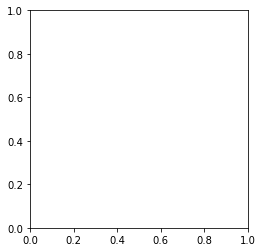

In [9]:
dataiter = iter(dataloaders['train'])
img, label = dataiter.next()
img, label = dataiter.next()
img, label = dataiter.next()
img, label = dataiter.next()
plt.imshow(img[1])
#show_lanes(utils.make_grid(img), utils.make_grid(label))
plt.show()
plt.imshow(img[2].permute(1,2,0))
#show_lanes(utils.make_grid(img), utils.make_grid(label))
plt.show()

In [ ]:
with torch.no_grad():
    pred = output_mask(img, model, device)
    plt.imshow(pred[1])
    plt.show()
    plt.imshow(pred[2])
    plt.show()
    #plt.imshow(img[0].detach().cpu().permute(1, 2, 0))

In [10]:
with torch.no_grad():
    start_time = time.time()
    dataiter = iter(dataloaders['test'])
    for i in range(100):
        img, label = dataiter.next()
        pred = output_mask(img, model, device)
    end_time = time.time()

print('Results are as following:')
print('Time for 100 Images : ', end_time - start_time, 'seconds')
print('FPS (GeForce 920M) : ', 100/(end_time - start_time), 'fps')

Results are as following:
Time for 100 Images :  11.69179368019104 seconds
FPS (GeForce 920M) :  8.553007582525698 fps


In [11]:
save_model(model, './model_gray')

Model saved to  ./model_gray


In [ ]:
test_transforms = transforms.Compose([
    transforms.Resize((480, 640)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], 
                         std=[0.5])
])

In [ ]:
mask = img_to_mask('web_images/input/4.jpg', model, test_transforms, device)

In [ ]:
plt.imshow(mask[0])
plt.show()